
# Pendulum

https://www.gymlibrary.ml/environments/classic_control/pendulum/

In [1]:
%matplotlib ipympl

import gym
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
env_name = "Pendulum-v1"
episode_length = 200

## Define Agent

### Do Nothing

In [4]:
class Agent():
    def __init__(self, env):
        pass

    def get_action(self, state):
        action = [0]
        return action

### Try to make it spin counter-clockwise

This may or may not work depending on the initial conditions.

In [28]:
class Agent():
    def __init__(self, env):
        pass

    def get_action(self, state):
        action = [2]
        return action

### Spin in circles

Go either direction

In [45]:
class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state):
        x, y, the_d = state
        the = np.arctan2(y, x)

        if the_d > 0:
            action = [2]
        if the_d < 0:
            action = [-2]
    
        return action

Spin in a particular direction

In [38]:
direction = 'counter-clockwise' # 'counter' or 'counter-clockwise'

class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state):
        x, y, the_d = state
        the = np.arctan2(y, x)
        action = [0]
        if direction == 'clockwise':
            if the_d < 0:
                action = [-2]
        if direction == 'counter-clockwise':
            if the_d > 0:
                action = [2]
    
        return action

### Manual Controller

In [14]:
from enum import Enum

class Phase(Enum):
    SWING_UP = 0
    ARREST = 1
    BALANCE = 2
    FINE_BALANCE = 3

class Fsm:
    def __init__(self,):
        self.phase = Phase.SWING_UP

    def update_phase(self, observation):
        x, y, w = observation
        the = np.arctan2(y,x)
        a = w - state[len(state)-1][1] if len(state) > 0 else 0

        if abs(the) < 0.05:
            self.phase = Phase.FINE_BALANCE
        elif abs(the) < np.pi/2 and abs(w) > 2.5 and the * w < 0:
            self.phase = Phase.ARREST
        elif abs(the) >= np.pi/2:
            self.phase = Phase.SWING_UP
        else:
            self.phase = Phase.BALANCE
            
        return self.phase

class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state, phase):
        x, y, the_d = state
        the = np.arctan2(y, x)
        self.angle_integral += the
        action = [0] # Default do nothing
        
        if phase == Phase.SWING_UP:
            if the_d > 0:
                action = [2]
            if the_d < 0:
                action = [-2]
        
        if phase == Phase.ARREST:
            if the_d > 0:
                action = [-2]
            if the_d < 0:
                action = [2]
        if phase == Phase.BALANCE or phase == Phase.FINE_BALANCE:
            action = get_pid_action(the, the_d, self.angle_integral)

        return action

def get_inverse_the_action(the):
    factor = -0.5
    return [np.clip(factor * the, -2, 2)]

def get_inverse_w_action(the_d):
    factor = -2
    return [np.clip(factor * the_d, -2, 2)]

kp = 2.4
kd = 5
ki = 0

def get_pid_action(the, the_d, the_int):
    # PID control
    composite = (-1 * kp * the) + (-1 * kd * the_d) + (-1 * ki * the_int)
    return [np.clip(composite, -2, 2)]



### PID Controller

In [125]:
class Agent():
    def __init__(self, env):
        self.angle_integral = 0
        
    def get_action(self, state):
        x, y, the_d = state
        the = np.arctan2(y, x)
        self.angle_integral += the
        p = 0.6
        d = 0.4
        i = 0.1
        composite = (-1 * p * the) + (-1 * d * the_d) # + i * self.angle_integral
        action = [np.clip(composite, -2, 2)]
        return action

## Live Plot

/Users/chewchiashaoyuan/.local/share/virtualenvs/openai-gym-ivwuKYuv/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/var/folders/sl/37m0k__51_3_5c5j02w201r40000gn/T/ipykernel_12067/3881468723.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which="both")


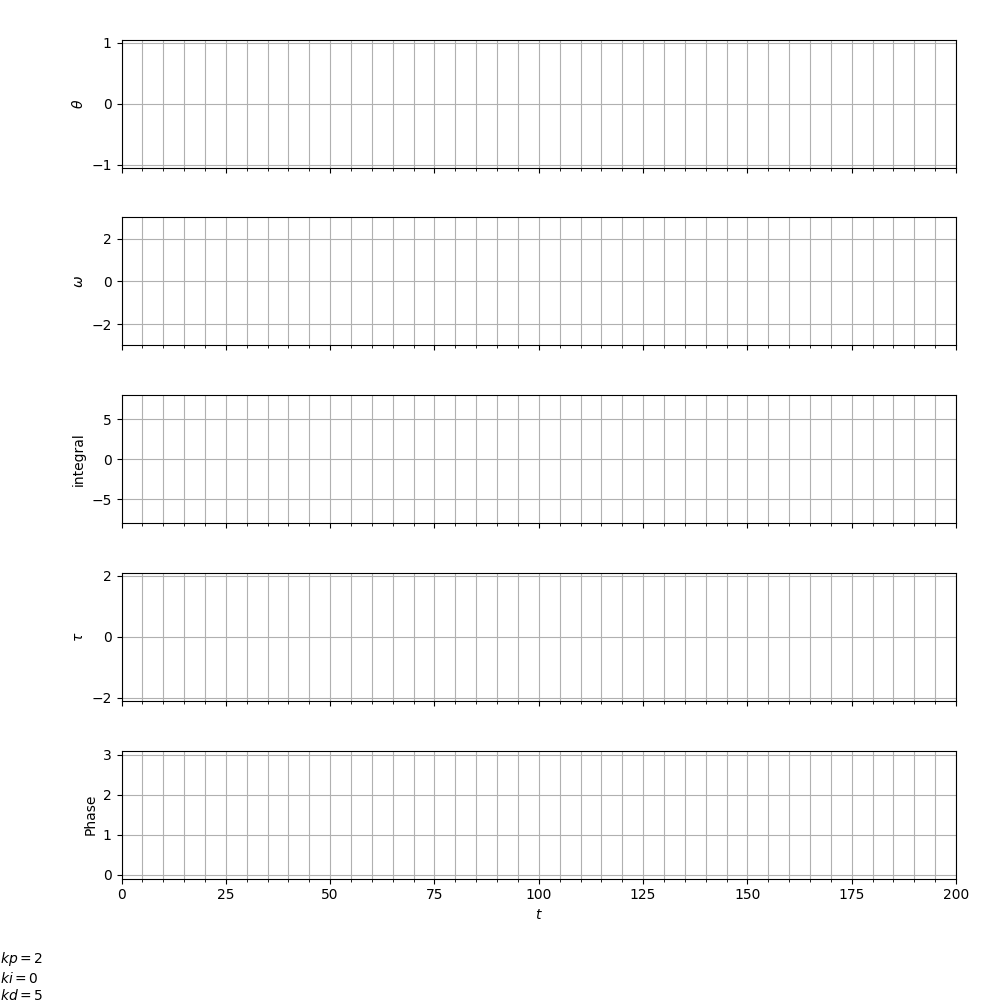

In [4]:
num_subplots = 5
fig, axes = plt.subplots(num_subplots,1)
lines = []

# Set common settings
for i, ax in enumerate(axes):
    ax.grid(b=True, which="both")
    ax.set_xlim(0,episode_length)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
    lines.append(ax.plot([], []))
    if i != len(axes)-1:
        ax.get_xaxis().set_ticklabels([])

axes[0].set_ylabel(r'$\theta$')
axes[0].set_ylim(-np.pi/3, np.pi/3)
axes[1].set_ylabel(r'$\omega$')
axes[1].set_ylim(-3, 3)
axes[2].set_ylabel('integral')
axes[2].set_ylim(-8, 8)
axes[3].set_ylabel(r'$\tau$')
axes[3].set_ylim(-2.1, 2.1)
axes[4].set_ylabel('Phase')
axes[4].set_ylim(-0.1, 3.1)

ax.set_xlabel(r'$t$')
annotation_text = '\n'.join([f'$kp={kp}$', f'$ki={ki}$', f'$kd={kd}$'])
fig.text(0,0, annotation_text)

fig.tight_layout()
fig.set_size_inches(10,10)

state = []
frames = []

def plot_state(observation, the_int, action, phase, frame_no):
    x, y, w = observation
    the = np.arctan2(y,x)
    a = w - state[len(state)-1][1] if len(state) > 0 else 0 
    tau = action[0]
    state.append([the, w, the_int, tau, phase.value])
    frames.append(frame_no)
    
    transpose = np.array(state).T
    
    for i in range (num_subplots):
        lines[i][0].set_data(frames, transpose[i])

    fig.canvas.draw()


## Run Environment

In [15]:
env = gym.make(env_name)
agent = Agent(env)
rewards = list()

for i_episode in range(1):
    state.clear()
    frames.clear()
    fsm = Fsm()
    observation = env.reset()
    for t in range(500):
        env.render()
        phase = fsm.update_phase(observation)
        action = agent.get_action(observation, phase)
        the_int = agent.angle_integral
        plot_state(observation, the_int, action, phase, t)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            rewards.append(reward)
            
            break
            
print(f"Final Rewards:{rewards}")
env.close()


Episode finished after 200 timesteps
Final Rewards:[-0.006017632307930866]


In [43]:
plt.close('all')